In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as npA
import imageio
import cv2
import os

from tensorflow.keras.optimizers import Adam

In [3]:
IMG_SIZE = 224

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [5]:
path = 'C:/Users/aminb/Downloads/RNN/sports_dataset'
dataset_path = os.listdir( path)

label_types = os.listdir( path)
print (label_types)

['body-building', 'boxing', 'calesthenics', 'cycling', 'swimming', 'yoga']


In [6]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir( path + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str( path + '/' +item) + '/' + room))

# Build a dataframe
data = pd.DataFrame( data=rooms, columns=['tag', 'video_name'])
print(data.head())
print(data.tail())

             tag                                         video_name
0  body-building  C:/Users/aminb/Downloads/RNN/sports_dataset/bo...
1  body-building  C:/Users/aminb/Downloads/RNN/sports_dataset/bo...
2  body-building  C:/Users/aminb/Downloads/RNN/sports_dataset/bo...
3  body-building  C:/Users/aminb/Downloads/RNN/sports_dataset/bo...
4  body-building  C:/Users/aminb/Downloads/RNN/sports_dataset/bo...
       tag                                         video_name
1633  yoga  C:/Users/aminb/Downloads/RNN/sports_dataset/yo...
1634  yoga  C:/Users/aminb/Downloads/RNN/sports_dataset/yo...
1635  yoga  C:/Users/aminb/Downloads/RNN/sports_dataset/yo...
1636  yoga  C:/Users/aminb/Downloads/RNN/sports_dataset/yo...
1637  yoga  C:/Users/aminb/Downloads/RNN/sports_dataset/yo...


In [7]:
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras import Input, Model

def build_feature_extractor(model_name="inception_v3"):
    if model_name == "inception_v3":
        feature_extractor = InceptionV3(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.inception_v3.preprocess_input
    elif model_name == "vgg16":
        feature_extractor = VGG16(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.vgg16.preprocess_input
    else:
        raise ValueError("Invalid model name. Supported names: 'inception_v3', 'vgg16'")

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return Model(inputs, outputs, name=f"{model_name}_feature_extractor")

# To use InceptionV3
inception_feature_extractor = build_feature_extractor(model_name="inception_v3")

# To use VGG16
vgg16_feature_extractor = build_feature_extractor(model_name="vgg16")

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 512

In [9]:
X_train = []
X_test = []

X_train.append(np.load('npys/train_features.npy'))
X_train.append(np.load('npys/train_masks.npy'))
y_train = np.load('npys/train_labels.npy')

X_test.append(np.load('npys/test_features.npy'))
X_test.append(np.load('npys/test_masks.npy'))
y_test = np.load('npys/test_labels.npy')

In [10]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique( label_types))

c:\Users\aminb\anaconda3\Lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [11]:
print(f"Frame features in train set: {X_train[0].shape}")
print(f"Frame masks in train set: {X_train[1].shape}")



print(f"train_labels in train set: { y_train.shape}")

print(f"test_labels in train set: { y_test.shape}")


Frame features in train set: (1310, 20, 512)
Frame masks in train set: (1310, 20)
train_labels in train set: (1310, 1)
test_labels in train set: (328, 1)


In [12]:
from tensorflow.keras import regularizers

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # LSTM layers with L2 regularization
    x = keras.layers.LSTM( 128, return_sequences=True, stateful=False)(frame_features_input, mask=mask_input)
    x = keras.layers.LSTM( 32, return_sequences=True, stateful=False)(x)

    # Flatten, BatchNormalization, and Dropout
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Dense layers with L2 regularization
    x = keras.layers.Dense(8, activation="relu", kernel_regularizer=regularizers.l1(1e-4))(x)
    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"]
    )
    return rnn_model



def run_experiment():
    
    from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

    model_save = ModelCheckpoint( 'models/best_model_1_12.keras',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose= 1)
    
    rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.1,
                            patience=5,
                            verbose=0,
                            mode="max",
                            min_delta=0.001)
    
    es = EarlyStopping(monitor='val_loss', 
                                    patience=3, 
                                    restore_best_weights=True)

    seq_model = get_sequence_model()
    #seq_model.load_weights( 'models/best_model_30_11.keras')
    
    history = seq_model.fit(
        [X_train[0], X_train[1]],
        y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[ model_save, es, rlr],
    )

    #seq_model.load_weights(filepath)
    #_, accuracy = seq_model.evaluate([ X_test, X_test], y_test)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history,sequence_model = run_experiment()

Epoch 1/100


33/33 [==============================] - ETA: 0s - loss: 1.7948 - accuracy: 0.3502

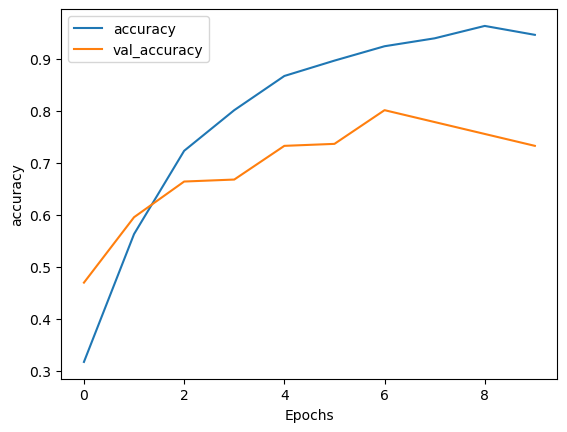

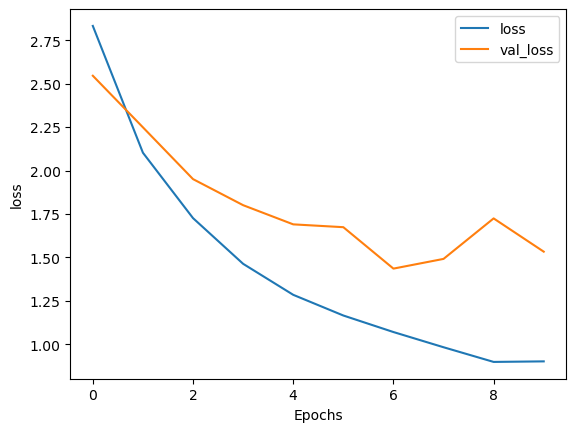

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs( history, "accuracy")
plot_graphs( history, "loss")

In [ ]:
sequence_model.evaluate( [ X_test[0], X_test[1]], y_test)

11/11 [==============================] - 0s 18ms/step - loss: 1.3840 - accuracy: 0.8262


[1.384036660194397, 0.8262194991111755]